Group members:  
Name: Yao Jingyuan    StudentID: 2001212407  
Name: Gao Xiang    StudentID: 2001212335

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from arch.unitroot import PhillipsPerron,DFGLS
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

## Macroeconomic Data

To construct our indicator, we download some macroeconomic data from Wind Data Service. Since a subscription account is required to get access to Wind Data Service, we just downloaded the data and put it on the GitHub within our project. 
In particular, the variables we obtained are displayed below in code cell.

Since we want our indicator to implicate the correlation of supply, demand, and inflation of macroeconomy of China, 
we select variables from these three aspects.

In [31]:
data = pd.read_csv('https://raw.githubusercontent.com/koueihei/Project-for-math-data-skills-YG/main/Data_and_code/MacroData.csv')
data = data.assign(Dates=pd.to_datetime(data.Dates)).set_index('Dates')

datainfo = {}
for ts in data.columns:

    datainfo[ts]={
        'Count':data[ts].count(),
        'Start point': data[ts].dropna().index[0].strftime("%m/%d/%Y"),
        'End point': data[ts].dropna().index[-1].strftime("%m/%d/%Y")
        }
datainfo_df = pd.DataFrame(datainfo)#.items(),columns=['Var','P values of P-p test'])

datainfo_df=datainfo_df.T 
mapper =  {
        'Count':'{:.0f}',
        }

datainfo_df.style.format(mapper)

,Count,Start point,End point
Average daily coal consumption,3916,10/01/2009,07/06/2020
Operating rate of blast furnaces,475,08/03/2012,12/24/2021
All-steel wheel operating rate,414,06/01/2013,01/06/2022
Semi-steel wheel operating rate,410,07/18/2013,01/06/2022
Polyester filament operating rate,508,09/04/2013,01/06/2022
PTA operating rate,413,09/01/2013,01/07/2022
Average daily output of crude steel,459,01/10/2009,12/20/2021
Commercial housing transaction area of 30 cities(D),4392,01/01/2010,01/09/2022
Commercial housing transaction area of 30 cities(W),628,01/03/2010,01/09/2022
Cement Price Index,2402,09/09/2011,01/10/2022


To denote which aspect a variable represent, we create a mapping to index them, where "s" represents supply, "d" represents demand, and "p" represents inflation or price level. For instance, "s1" represents "Average daily coal consumption", the first variable from supply aspect.

In [32]:
keys = ('s1','s2','s3','s4','s5','s6','s7','d1','d2','d3','d4','d5','d6','d7','p1','p2','p3','s8','s9','s10','s11','s12')
indexing = dict(zip(data.columns.to_list(),keys))
reindexing = dict(zip(keys,data.columns.to_list()))

For data missing problem, we only select the data from Jun/10/2016 to Dec/31/2021.
As for missing data points within this period, we use linear interpolation to fill them.
Since many variables have trends, we take first difference to make them stationary.
The cleaned data are contained in data3.

In [43]:
data1 = data.rename(columns = indexing).interpolate(method='linear')
data2 = data1.resample('W').mean().loc['2016-06-19':'2021-12-31',:]
data3 = data2.pct_change().dropna(how='all',axis=0)
data3.loc['2020-7-13':,'s1'] = np.nan


### Basic Statistical Description of Data and Unit Root Test 

In [44]:
#basic description of variables
data3info = {}
for ts in data3.columns:
    pp = PhillipsPerron(data3[ts].dropna())#PhillipsPerron(data3[ts].dropna())
    data3info[reindexing[ts]]={
        'index':ts,
        'P values <br> of P-p test':pp.pvalue, #print newline within a cell of pandas
        'Mean':data3[ts].mean(),
        'Count':data3[ts].count(),
        'Std':data3[ts].std(),
        'Skewness':data3[ts].skew(),
        'Kurtosis':data3[ts].kurtosis(),
        'Start point': data3[ts].dropna().index[0].strftime("%m/%d/%Y"),
        'End point': data3[ts].dropna().index[-1].strftime("%m/%d/%Y")
        }
data3info_df = pd.DataFrame(data3info)#.items(),columns=['Var','P values of P-p test'])

data3info_df=data3info_df.T 
mapper =  {
        'P values <br> of P-p test':'{0:.2e}',
        'Mean':'{0:.3f}',
        'Count':'{:.0f}',
        'Skewness':'{0:.3f}',
        'Kurtosis':'{0:.3f}'
        }

data3info_df.sort_values('index').style.format(mapper)

,index,P values of P-p test,Mean,Count,Std,Skewness,Kurtosis,Start point,End point
Commercial housing transaction area of 30 cities(D),d1,4.01e-30,0.105,288,0.809328,8.473,85.929,06/26/2016,12/26/2021
Commercial housing transaction area of 30 cities(W),d2,3.48e-24,0.035,288,0.327938,6.219,64.380,06/26/2016,12/26/2021
Cement Price Index,d3,1.69e-04,0.003,288,0.014577,2.207,10.875,06/26/2016,12/26/2021
Average Daily Sales of Passenger Car(Wholesale),d4,2.06e-30,0.061,288,0.367120,1.615,7.937,06/26/2016,12/26/2021
Average Daily Sales of Passenger Car(Retail),d5,0.00e+00,0.060,288,0.350020,0.759,1.746,06/26/2016,12/26/2021
Keqiao Textile Price Index,d6,3.64e-16,0.000,288,0.001505,-0.020,2.122,06/26/2016,12/26/2021
CCFI composite index,d7,4.06e-05,0.006,288,0.017604,1.099,2.703,06/26/2016,12/26/2021
Edible Agricultural Products Price Index,p1,1.35e-05,0.000,288,0.010150,0.376,2.147,06/26/2016,12/26/2021
Production price index,p2,1.63e-10,0.002,288,0.007235,1.824,12.310,06/26/2016,12/26/2021
WTI spot price,p3,2.19e-26,0.006,288,0.103793,8.206,121.001,06/26/2016,12/26/2021


### Select Data to Represent Supply, Demand, and Inflation

Since the variables we get may have multicolinearity within one aspect, we further select the data to get rid of it.

#### Variables of Supply

In [45]:
# Variables of supply

setS = ['s1','s2','s3','s5','s6','s8']
print(np.corrcoef(data3[setS].dropna().T))


[[ 1.          0.04421198  0.28707713  0.30549748  0.03734154  0.3127957 ]
 [ 0.04421198  1.          0.07853942  0.00480322 -0.04282329  0.24113744]
 [ 0.28707713  0.07853942  1.          0.67573823 -0.11027179  0.0071115 ]
 [ 0.30549748  0.00480322  0.67573823  1.         -0.11738447  0.10021514]
 [ 0.03734154 -0.04282329 -0.11027179 -0.11738447  1.         -0.01712484]
 [ 0.3127957   0.24113744  0.0071115   0.10021514 -0.01712484  1.        ]]


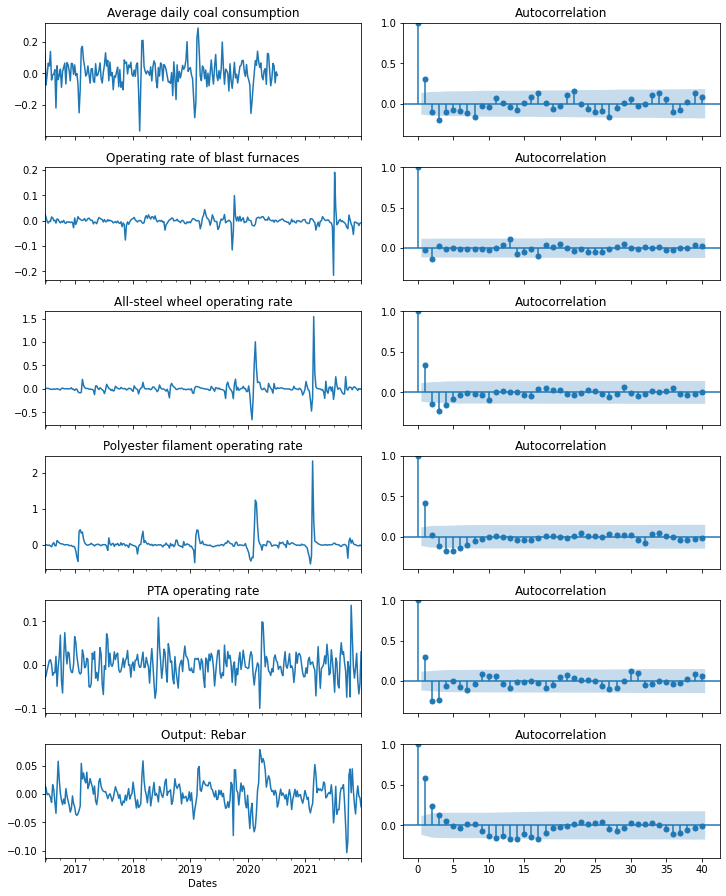

In [46]:
fig1, ax1 = plt.subplots(6,2,figsize=(10,12))
fig1.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)
for i,ts in enumerate(setS):
    data3[ts].plot(ax=ax1[i,0])
    plot_acf(data3[ts].dropna(), lags=40,ax=ax1[i,1])
    ax1[i,0].set_title(reindexing[ts])
    ax1[i,1].set_title('Autocorrelation')
    ax1[i,1].set_ylim([-0.4,1])
    ax1[i,0].sharex(ax1[0,0])
    ax1[i,1].sharex(ax1[0,1])

#### Variables of Demand

In [47]:
# Variables of Demand

setD = ['d2','d3','d5','d6','d7']
print(np.corrcoef(data3[setD].dropna().T))

[[ 1.00000000e+00 -8.76630149e-02  2.47389064e-01  8.63547976e-02
  -1.70524010e-01]
 [-8.76630149e-02  1.00000000e+00  7.59510897e-04  4.77053495e-02
  -4.77956901e-02]
 [ 2.47389064e-01  7.59510897e-04  1.00000000e+00 -7.30288395e-02
  -2.45011092e-02]
 [ 8.63547976e-02  4.77053495e-02 -7.30288395e-02  1.00000000e+00
  -3.73765588e-02]
 [-1.70524010e-01 -4.77956901e-02 -2.45011092e-02 -3.73765588e-02
   1.00000000e+00]]


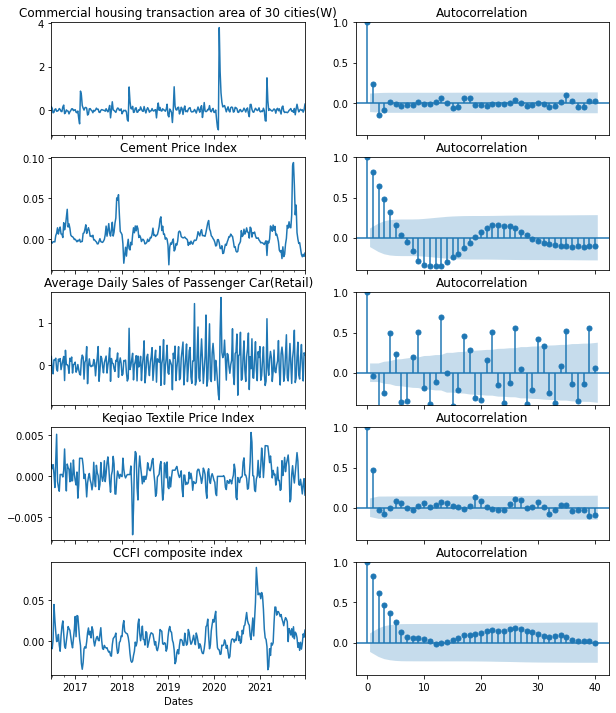

In [48]:
fig2, ax2 = plt.subplots(5,2,figsize=(10,12))
fig1.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)
for i,ts in enumerate(setD):
    data3[ts].plot(ax=ax2[i,0])
    plot_acf(data3[ts].dropna(), lags=40,ax=ax2[i,1])
    ax2[i,0].set_title(reindexing[ts])
    ax2[i,1].set_title('Autocorrelation')
    ax2[i,1].set_ylim([-0.4,1])
    ax2[i,0].sharex(ax2[0,0])
    ax2[i,1].sharex(ax2[0,1])

#### Variables of Price

In [49]:
# Variables of Price

setP = ['p1','p2','p3']
print(np.corrcoef(data3[setD].dropna().T))

[[ 1.00000000e+00 -8.76630149e-02  2.47389064e-01  8.63547976e-02
  -1.70524010e-01]
 [-8.76630149e-02  1.00000000e+00  7.59510897e-04  4.77053495e-02
  -4.77956901e-02]
 [ 2.47389064e-01  7.59510897e-04  1.00000000e+00 -7.30288395e-02
  -2.45011092e-02]
 [ 8.63547976e-02  4.77053495e-02 -7.30288395e-02  1.00000000e+00
  -3.73765588e-02]
 [-1.70524010e-01 -4.77956901e-02 -2.45011092e-02 -3.73765588e-02
   1.00000000e+00]]


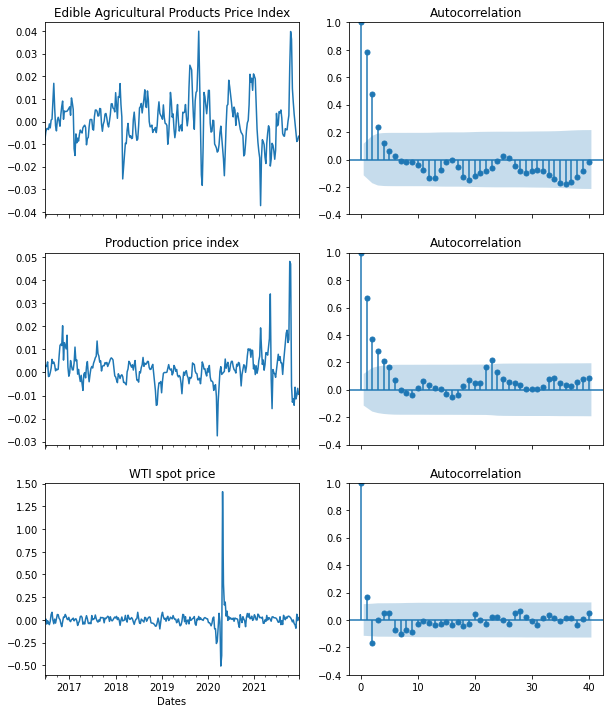

In [50]:
fig3, ax3 = plt.subplots(3,2,figsize=(10,12))
fig1.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)
for i,ts in enumerate(setP):
    data3[ts].plot(ax=ax3[i,0])
    plot_acf(data3[ts].dropna(), lags=40,ax=ax3[i,1])
    ax3[i,0].set_title(reindexing[ts])
    ax3[i,1].set_title('Autocorrelation')
    ax3[i,1].set_ylim([-0.4,1])
    ax3[i,0].sharex(ax3[0,0])
    ax3[i,1].sharex(ax3[0,1])

In [51]:
#automatically drop s1 when there is no available data for s1
def check_nan(data):
    '''
    ckeck if there are any nans in data and drop them.
    input -> pandas dataframe
    return -> data without nan, number of series remained
    '''
    checker = data.isnull().any(axis=0)
    if checker.any()==True:
        columns = checker[checker == 0].index.tolist()
        return data[columns], len(columns)
    else:
        return data, data.shape[1]


# Commodity Prices Data

In this section, we downloaded the price data of 45 mainstream commodities in China market from 2016 to 2021 considering the availability of the macroeconomic data.The data are downloaded from Wind Financial Service. In particular, the variables we obtained are displayed below in code cell. As to be shown, these commodities can be categorized into 5 types, including agriculture, energy and chemicals, non-ferrous metals, soft commodity and ferrous metals.

Also, we included 1 commodity price index (NHCI) in the data.

In [12]:
data_c = pd.read_excel('CommodityPrices.xlsx')
data_c = data_c.assign(Dates=pd.to_datetime(data_c.Dates)).set_index('Dates')

data_c_info = {}
for ts in data_c.columns:

    data_c_info[ts]={
        'Count':data_c[ts].count(),
        'Start point': data_c[ts].dropna().index[0].strftime("%m/%d/%Y"),
        'End point': data_c[ts].dropna().index[-1].strftime("%m/%d/%Y")
        }
data_c_info_df = pd.DataFrame(data_c_info)#.items(),columns=['Var','P values of P-p test'])

data_c_info_df=data_c_info_df.T 
mapper_c =  {
        'Count':'{:.0f}',
        }

data_c_info_df.style.format(mapper_c)

,Count,Start point,End point
M,1461,01/04/2016,12/31/2021
OI,1461,01/04/2016,12/31/2021
P,1461,01/04/2016,12/31/2021
Y,1461,01/04/2016,12/31/2021
RM,1461,01/04/2016,12/31/2021
C,1461,01/04/2016,12/31/2021
CS,1461,01/04/2016,12/31/2021
JD,1461,01/04/2016,12/31/2021
A,1461,01/04/2016,12/31/2021
MA,1461,01/04/2016,12/31/2021


The meaning for codes of these commodities are as follows:  
    M: bean pulp commodity  
   OI: colleseed oil  
    P: palm oil  
    Y: soya-bean oil  
   RM: rapeseed dregs  
    C: corn  
   CS: corn starch  
   JD: eggs  
    A: yellow soybean  
   MA: methyl alcohol  
   SC: crude oil  
   BU: bitumen  
    V: poluvinyl chloride  
    L: polyethylene  
   TA: purified terephthalic acid  
   PP: polypropylene  
   FU: fuel oil  
   PG: Liquefied petroleum gas  
   EG: ethylene glycol  
   UR: urea  
   SA: sodium carbonate  
   EB: styrene  
   CU: cuprum  
   AL: aluminum  
   NI: nickel  
   ZN: zinc  
   PB: plumbum  
   AU: gold  
   AG: Silver  
   SS: stainless steel  
   RU: raw rubber  
   SR: sugar  
   CF: cotton floss  
   SP: paper pulp  
   AP: apple  
   CJ: red dates  
   HC: hot rolled plate  
    I: iron ore  
   RB: rebar  
    J: coke  
   JM: coking coal  
   ZC: steam coal  
   SM: manganese-silicon  
   SF: ferrosilicon  
   FG: glass  
  NHCI: Nanhua commodity index  
  
  Similarly, to denote which aspect a variable represent, we create another mapping to index them, where "AG" represents agricultural commodities, "EC" represents energy and chemicals commodities, "NFM" represents non-ferrous metals, "SFT" represents soft commodity, "FM" represents ferrous metals, and "CI" represents commodity price index. For instance, "AG1" represents "M" commodity (bean pulp), the first variable from agricultural commodities.

In [13]:
keys = ('AG1','AG2','AG3','AG4','AG5','AG6','AG7','AG8','AG9',
        'EC1','EC2','EC3','EC4','EC5','EC6','EC7','EC8','EC9','EC10','EC11','EC12','EC13',
       'NFM1','NFM2','NFM3','NFM4','NFM5','NFM6','NFM7','NFM8',
       'SFT1','SFT2','SFT3','SFT4','SFT5','SFT6',
       'FM1','FM2','FM3','FM4','FM5','FM6','FM7','FM8','FM9',
       'CI')
indexing = dict(zip(data_c.columns.to_list(),keys))
reindexing = dict(zip(keys,data_c.columns.to_list()))

For data missing problem, we only select the data from Jun/10/2016 to Dec/31/2021, which is the same for the macroeconomic data. As for missing data points within this period, we use linear interpolation to fill them. The cleaned data are contained in data_c3.

In [14]:
data_c1 = data_c.rename(columns = indexing).interpolate(method='linear')
data_c2 = data_c1.resample('W').mean().loc['2016-06-19':'2021-12-31',:]
data_c3 = data_c2.pct_change().dropna(how='all',axis=0)

# Basic Statistical Description of Data and Unit Root Test

In [15]:
#basic description of variables
data_c3info = {}
for ts in data_c3.columns:
    pp = PhillipsPerron(data_c3[ts].dropna())#PhillipsPerron(data3[ts].dropna())
    data_c3info[reindexing[ts]]={
        'index':ts,
        'P values <br> of P-p test':pp.pvalue, #print newline within a cell of pandas
        'Mean':data_c3[ts].mean(),
        'Count':data_c3[ts].count(),
        'Std':data_c3[ts].std(),
        'Skewness':data_c3[ts].skew(),
        'Kurtosis':data_c3[ts].kurtosis(),
        'Start point': data_c3[ts].dropna().index[0].strftime("%m/%d/%Y"),
        'End point': data_c3[ts].dropna().index[-1].strftime("%m/%d/%Y")
        }
data_c3info_df = pd.DataFrame(data_c3info)#.items(),columns=['Var','P values of P-p test'])

data_c3info_df=data_c3info_df.T 
mapper =  {
        'P values <br> of P-p test':'{0:.2e}',
        'Mean':'{0:.3f}',
        'Count':'{:.0f}',
        'Skewness':'{0:.3f}',
        'Kurtosis':'{0:.3f}'
        }

data_c3info_df.sort_values('index').style.format(mapper)

,index,P values of P-p test,Mean,Count,Std,Skewness,Kurtosis,Start point,End point
M,AG1,1.15e-27,0.000,288,0.022089,-0.294,2.533,06/26/2016,12/26/2021
OI,AG2,3.44e-27,0.003,288,0.020600,0.326,1.595,06/26/2016,12/26/2021
P,AG3,2.26e-28,0.002,288,0.028328,-0.633,4.063,06/26/2016,12/26/2021
Y,AG4,4.98e-28,0.001,288,0.021783,-0.404,1.666,06/26/2016,12/26/2021
RM,AG5,2.42e-28,0.001,288,0.024202,0.204,0.058,06/26/2016,12/26/2021
C,AG6,3.40e-27,0.002,288,0.014100,0.059,0.527,06/26/2016,12/26/2021
CS,AG7,1.03e-24,0.001,288,0.017612,-0.020,2.521,06/26/2016,12/26/2021
JD,AG8,1.47e-25,0.001,288,0.038489,1.647,8.427,06/26/2016,12/26/2021
A,AG9,1.74e-27,0.002,288,0.022327,0.600,1.209,06/26/2016,12/26/2021
NHCI,CI,6.88e-25,0.003,288,0.017780,-0.163,1.021,06/26/2016,12/26/2021


# Select Data to Represent Different types of Commodities

As we will see, all the weekly returns time series of these commodities have no unit root. Thus, the returns data are stable throughout the period we select.

## Variables of Agricultural Commodities

In [16]:
# Variables of agricultural commodities

set_AG = ['AG1','AG2','AG3','AG4','AG5','AG6','AG7','AG8','AG9']
print(np.corrcoef(data_c3[set_AG].dropna().T))


[[1.         0.22657599 0.19398317 0.28681328 0.85385105 0.25728458
  0.168587   0.18738388 0.31845308]
 [0.22657599 1.         0.67904099 0.73572349 0.26522397 0.11103902
  0.11336219 0.1694494  0.23805347]
 [0.19398317 0.67904099 1.         0.85870938 0.20209573 0.09615636
  0.06670939 0.05001405 0.21801199]
 [0.28681328 0.73572349 0.85870938 1.         0.25403956 0.12186945
  0.0943559  0.06789357 0.27256484]
 [0.85385105 0.26522397 0.20209573 0.25403956 1.         0.25516778
  0.19174398 0.16404995 0.28583746]
 [0.25728458 0.11103902 0.09615636 0.12186945 0.25516778 1.
  0.70400212 0.15751565 0.22304791]
 [0.168587   0.11336219 0.06670939 0.0943559  0.19174398 0.70400212
  1.         0.14008403 0.13026457]
 [0.18738388 0.1694494  0.05001405 0.06789357 0.16404995 0.15751565
  0.14008403 1.         0.09300113]
 [0.31845308 0.23805347 0.21801199 0.27256484 0.28583746 0.22304791
  0.13026457 0.09300113 1.        ]]


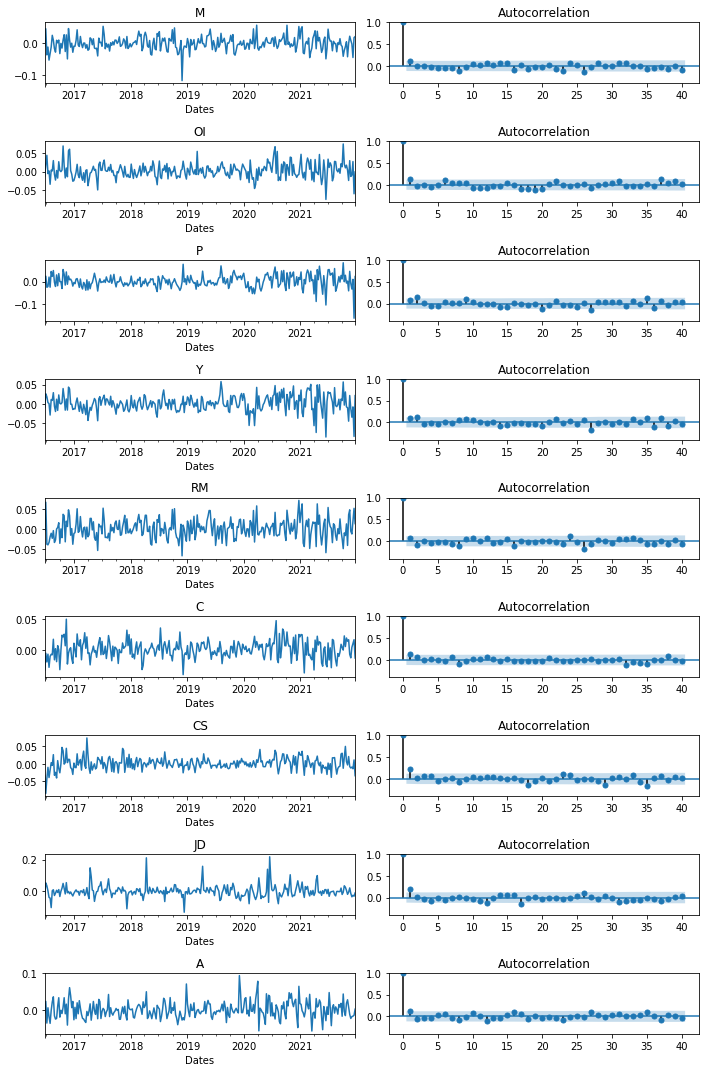

In [17]:
fig_c1, ax_c1 = plt.subplots(9,2,figsize=(10,15))
fig_c1.tight_layout(pad=0.9, w_pad=0.8, h_pad=1)
for i,ts in enumerate(set_AG):
    data_c3[ts].plot(ax=ax_c1[i,0])
    plot_acf(data_c3[ts].dropna(), lags=40,ax=ax_c1[i,1])
    ax_c1[i,0].set_title(reindexing[ts])
    ax_c1[i,1].set_title('Autocorrelation')
    ax_c1[i,1].set_ylim([-0.4,1])
    
plt.tight_layout() 
plt.show()

## Variables of Energy and Chemicals

In [18]:
# Variables of Energy and Chemicals

set_EC = ['EC1','EC2','EC3','EC4','EC5','EC6','EC7','EC8','EC9','EC10','EC11','EC12','EC13']
print(np.corrcoef(data_c3[set_EC].dropna().T))

[[ 1.          0.30529195  0.24502938  0.61179711  0.59801849  0.38544219
   0.60329659  0.4219715   0.43678805  0.6741577   0.29029194  0.41664266
   0.37978057]
 [ 0.30529195  1.          0.65374008  0.23198284  0.37583471  0.64857699
   0.36714669  0.81862113  0.26098328  0.39395578  0.13022792 -0.05175499
   0.4090213 ]
 [ 0.24502938  0.65374008  1.          0.33876198  0.43017485  0.56639487
   0.4538972   0.55531095  0.37784853  0.33871434  0.04874515 -0.07180695
   0.4459734 ]
 [ 0.61179711  0.23198284  0.33876198  1.          0.70497185  0.38062105
   0.70167816  0.34285642  0.47044463  0.4817681   0.47764178  0.40595402
   0.35332057]
 [ 0.59801849  0.37583471  0.43017485  0.70497185  1.          0.45883936
   0.90305853  0.40409965  0.4066162   0.59690895  0.21191756  0.30500179
   0.52528499]
 [ 0.38544219  0.64857699  0.56639487  0.38062105  0.45883936  1.
   0.46393144  0.6827502   0.49463038  0.65324945  0.21712979  0.1019547
   0.45378766]
 [ 0.60329659  0.36714669  0.45

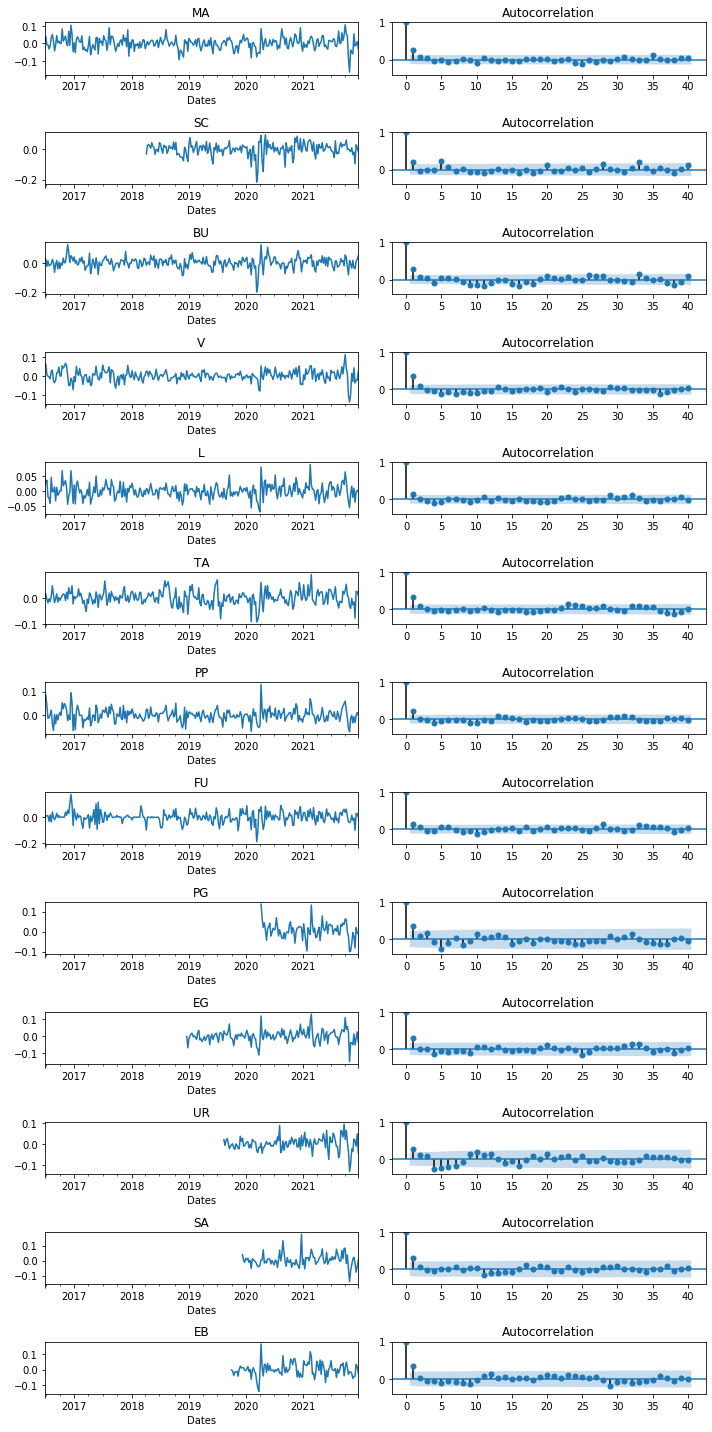

In [19]:
fig_c2, ax_c2 = plt.subplots(13,2,figsize=(10,20))
fig_c2.tight_layout(pad=0.9, w_pad=0.8, h_pad=1)
for i,ts in enumerate(set_EC):
    data_c3[ts].plot(ax=ax_c2[i,0])
    plot_acf(data_c3[ts].dropna(), lags=40,ax=ax_c2[i,1])
    ax_c2[i,0].set_title(reindexing[ts])
    ax_c2[i,1].set_title('Autocorrelation')
    ax_c2[i,1].set_ylim([-0.4,1])
    
plt.tight_layout() 
plt.show()

## Variables of Non-ferrous Metals

In [20]:
# Variables of Non-ferrous Metals

set_NFM = ['NFM1','NFM2','NFM3','NFM4','NFM5','NFM6','NFM7','NFM8']
print(np.corrcoef(data_c3[set_NFM].dropna().T))

[[ 1.          0.61964823  0.52685162  0.62993882  0.46298744  0.11993087
   0.30078195  0.36226451]
 [ 0.61964823  1.          0.38405037  0.55763037  0.18658096 -0.02890153
   0.18164579  0.4239191 ]
 [ 0.52685162  0.38405037  1.          0.51518531  0.40731554  0.09482274
   0.24072062  0.63558284]
 [ 0.62993882  0.55763037  0.51518531  1.          0.47466285  0.11468023
   0.33986557  0.4156043 ]
 [ 0.46298744  0.18658096  0.40731554  0.47466285  1.          0.22340202
   0.3097575   0.27770036]
 [ 0.11993087 -0.02890153  0.09482274  0.11468023  0.22340202  1.
   0.80632674  0.09485422]
 [ 0.30078195  0.18164579  0.24072062  0.33986557  0.3097575   0.80632674
   1.          0.16444065]
 [ 0.36226451  0.4239191   0.63558284  0.4156043   0.27770036  0.09485422
   0.16444065  1.        ]]


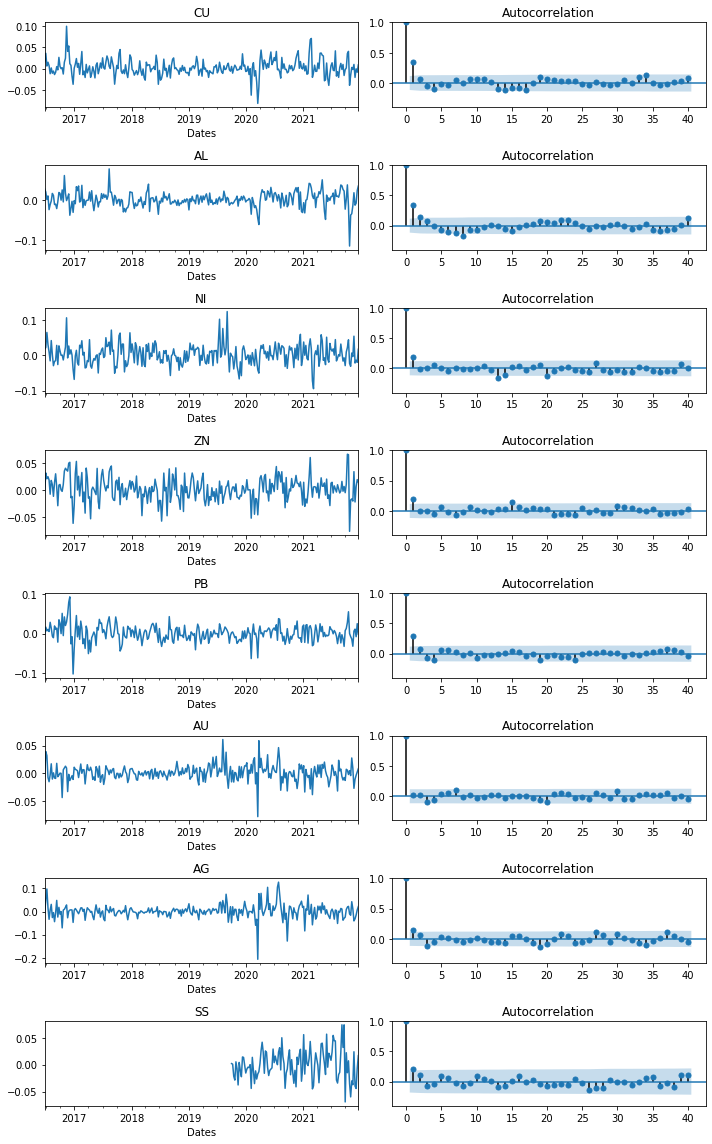

In [21]:
fig_c3, ax_c3 = plt.subplots(8,2,figsize=(10,16))
fig_c3.tight_layout(pad=0.9, w_pad=0.8, h_pad=1)
for i,ts in enumerate(set_NFM):
    data_c3[ts].plot(ax=ax_c3[i,0])
    plot_acf(data_c3[ts].dropna(), lags=40,ax=ax_c3[i,1])
    ax_c3[i,0].set_title(reindexing[ts])
    ax_c3[i,1].set_title('Autocorrelation')
    ax_c3[i,1].set_ylim([-0.4,1])
    
plt.tight_layout() 
plt.show()

## Variables of Soft Commodities

In [22]:
# Variables of Soft Commodities

set_SFT = ['SFT1','SFT2','SFT3','SFT4','SFT5','SFT6']
print(np.corrcoef(data_c3[set_SFT].dropna().T))

[[ 1.          0.29491116  0.5025742   0.09030018  0.03317348  0.12911288]
 [ 0.29491116  1.          0.35315978  0.12317046 -0.14805991  0.07456525]
 [ 0.5025742   0.35315978  1.          0.15718556  0.01019454  0.12643698]
 [ 0.09030018  0.12317046  0.15718556  1.         -0.28941017 -0.0413465 ]
 [ 0.03317348 -0.14805991  0.01019454 -0.28941017  1.          0.09017998]
 [ 0.12911288  0.07456525  0.12643698 -0.0413465   0.09017998  1.        ]]


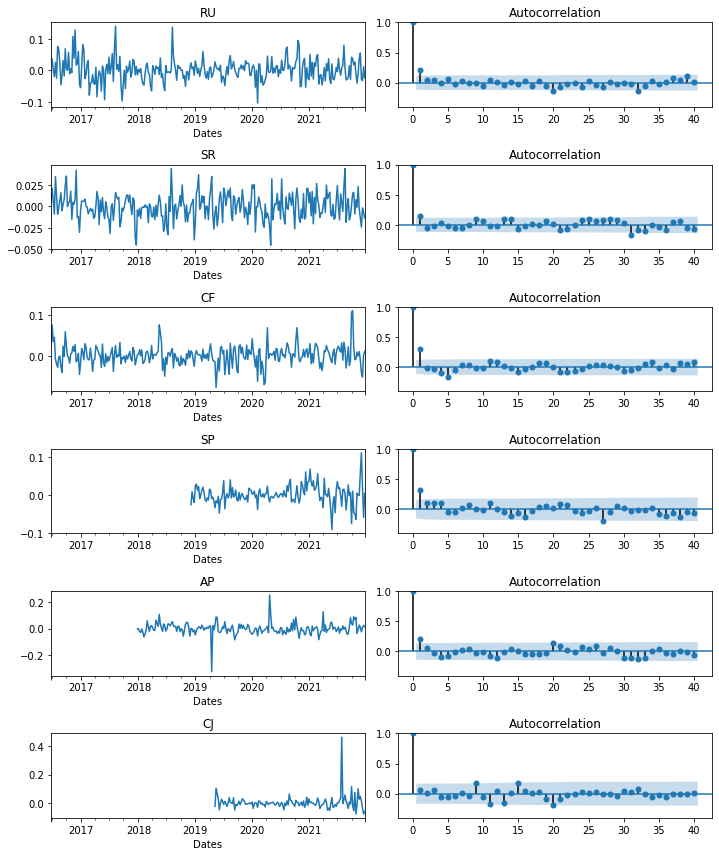

In [23]:
fig_c4, ax_c4 = plt.subplots(6,2,figsize=(10,12))
fig_c4.tight_layout(pad=0.9, w_pad=0.8, h_pad=1)
for i,ts in enumerate(set_SFT):
    data_c3[ts].plot(ax=ax_c4[i,0])
    plot_acf(data_c3[ts].dropna(), lags=40,ax=ax_c4[i,1])
    ax_c4[i,0].set_title(reindexing[ts])
    ax_c4[i,1].set_title('Autocorrelation')
    ax_c4[i,1].set_ylim([-0.4,1])

plt.tight_layout() 
plt.show()

## Variables of Ferrous Metals and Commodity Price Index

In [24]:
# Variables of Ferrous Metals

set_FM = ['FM1','FM2','FM3','FM4','FM5','FM6','FM7','FM8','FM9','CI']
print(np.corrcoef(data_c3[set_FM].dropna().T))

[[1.         0.64727012 0.87633795 0.56137358 0.43938184 0.30661796
  0.25935253 0.28117464 0.5774475  0.71240997]
 [0.64727012 1.         0.66276062 0.52319556 0.44889782 0.21018233
  0.28239965 0.24011268 0.48906178 0.70247754]
 [0.87633795 0.66276062 1.         0.61085028 0.4571327  0.29941149
  0.31639201 0.2970506  0.53639133 0.73711967]
 [0.56137358 0.52319556 0.61085028 1.         0.78064705 0.48643353
  0.38156565 0.34192615 0.40592884 0.66283752]
 [0.43938184 0.44889782 0.4571327  0.78064705 1.         0.57919975
  0.38102944 0.39765906 0.39664923 0.53871135]
 [0.30661796 0.21018233 0.29941149 0.48643353 0.57919975 1.
  0.35983684 0.47490586 0.31153627 0.30010688]
 [0.25935253 0.28239965 0.31639201 0.38156565 0.38102944 0.35983684
  1.         0.62508107 0.15651935 0.32912403]
 [0.28117464 0.24011268 0.2970506  0.34192615 0.39765906 0.47490586
  0.62508107 1.         0.2090718  0.32498128]
 [0.5774475  0.48906178 0.53639133 0.40592884 0.39664923 0.31153627
  0.15651935 0.20907

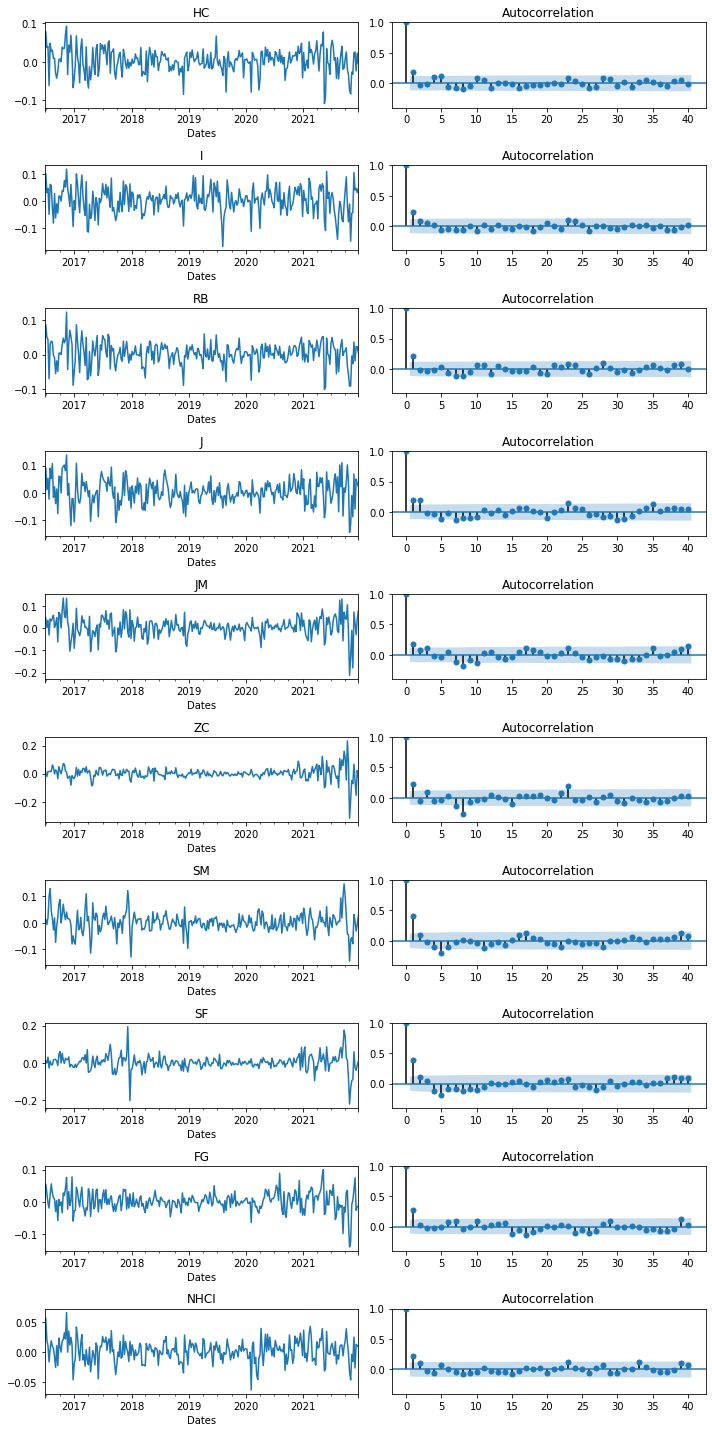

In [25]:
fig_c5, ax_c5 = plt.subplots(10,2,figsize=(10,20))
fig_c5.tight_layout(pad=0.9, w_pad=0.8, h_pad=1)
for i,ts in enumerate(set_FM):
    data_c3[ts].plot(ax=ax_c5[i,0])
    plot_acf(data_c3[ts].dropna(), lags=40,ax=ax_c5[i,1])
    ax_c5[i,0].set_title(reindexing[ts])
    ax_c5[i,1].set_title('Autocorrelation')
    ax_c5[i,1].set_ylim([-0.4,1])

plt.tight_layout() 
plt.show()